# Timesfm model for predict today's tesla stock price (yejin)

- reference 
: https://huggingface.co/google/timesfm-1.0-200m

* used python 3.11.11 in jupyter kernel on my mac

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from time import time
from datetime import date
import warnings
warnings.filterwarnings("ignore")

In [2]:
import timesfm
# For Torch
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=128,
          num_layers=50,
          use_positional_embedding=False,
          context_len=2048,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Jan 27 2025, 15:58:08) [Clang 16.0.0 (clang-1600.0.26.6)].


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# For Torch
tfm = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="gpu",
          per_core_batch_size=32,
          horizon_len=128,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-1.0-200m-pytorch"),
  )

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
# 1. Fetch stock data for TSLA
GetTSLA = yf.Ticker("TSLA")
TSLA_data=GetTSLA.history(period="max")
TSLA_data.reset_index(inplace=True)  # Reset index to make "Date" a column
TSLA_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
1,2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2,2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
3,2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
4,2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0


### Autocorrelation Analysis for Period Selection

To determine the appropriate sampling periods for the time series model, I analyzed the **Autocorrelation Function (ACF)** of the data. I generated ACF plots for both the **original stock price data** and the **differenced version** to observe any significant lags or periodic patterns.

Based on the results, I tested multiple sampling intervals (e.g., **5-day, 7-day, and 10-day** intervals) to find an optimal resampling frequency for the model input.

Since the **TimesFM model does not require stationarity**, I decided to proceed with the **original (non-differenced) data** while keeping the selected sampling periods.


Text(0.5, 1.0, 'Difference once')

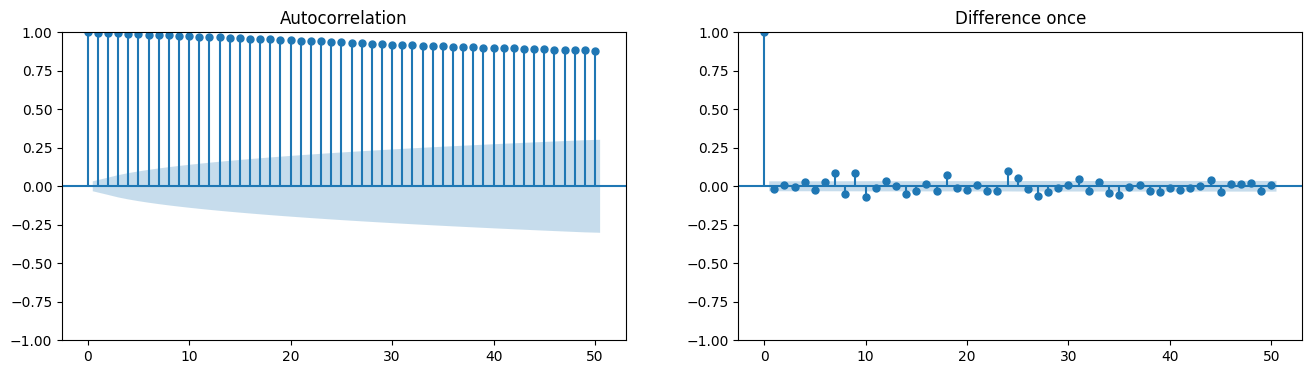

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

price = TSLA_data["Close"]
fig, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(16, 4))
price_diff = price.diff().dropna()


plot_acf(price, lags=50, ax=ax1)  # Check autocorrelation
plot_acf(price_diff, lags=50, ax=ax2)
ax2.set_title("Difference once")

In [7]:
# To check if the number of samples is enough
for days in [5, 7, 10, 14, 20]:
    print(f"Sampling every {days} days: {len(price.values[::days])} samples remaining")

Sampling every 5 days: 734 samples remaining
Sampling every 7 days: 524 samples remaining
Sampling every 10 days: 367 samples remaining
Sampling every 14 days: 262 samples remaining
Sampling every 20 days: 184 samples remaining


In [8]:
# 2. Prepare input data (resample and ensure 1D)
forecast_input = [
    np.array(price.values[::5]).flatten(),   # Every 5th day
    np.array(price.values[::7]).flatten(),  # Every 7th day
    np.array(price.values[::10]).flatten(),  # Every 10th day
]

# 3. Ensure all arrays have the same length
min_length = min(len(arr) for arr in forecast_input)
forecast_input = [arr[:min_length] for arr in forecast_input]

### Determining of the frequency input
In particular regarding the frequency, TimesFM expects a categorical indicator valued in {0, 1, 2}:

- 0 (default): high frequency, long horizon time series. We recommend using this for time series up to daily granularity.
- 1: medium frequency time series. We recommend using this for weekly and monthly data.
- 2: low frequency, short horizon time series. We recommend using this for anything beyond monthly, e.g. quarterly or yearly.
This categorical value should be directly provided with the array inputs. For dataframe inputs, we convert the conventional letter coding of frequencies to our expected categories, that

0: T, MIN, H, D, B, U

1: W, M

2: Q, Y

In [9]:
# 4. Frequency input 
frequency_input = [0]

In [10]:
#5. Build input dataframe for TimesFM
# Create the dataframe in the format required by TimesFM
input_df = pd.DataFrame({
    "unique_id": ["TSLA"] * len(TSLA_data),  # Use "TSLA" as the unique identifier
    "ds": TSLA_data["Date"],                # Date column
    "y": TSLA_data["Close"]                 # Closing price
})

# 3. Ensure y values are 1-dimensional
# Flatten y to ensure it is a 1D array
input_df["y"] = input_df["y"].values.flatten()


# 6. Forecast using TimesFM
# Pass the input dataframe to the TimesFM model for forecasting
forecast_df = tfm.forecast_on_df(
    inputs=input_df,  # Input dataframe
    freq="D",         # Dailt frequency
    value_name="y",   # The column to predict
    num_jobs=-1       # Use all available cores for parallel processing
)

# 7. Display forecast results
print(forecast_df)


Processing dataframe with multiple processes.
 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.11 (main, Jan 27 2025, 15:58:08) [Clang 16.0.0 (clang-1600.0.26.6)].
Finished preprocessing dataframe.
Finished forecasting.
    unique_id                        ds     timesfm  timesfm-q-0.1  \
0        TSLA 2025-01-28 00:00:00-05:00  393.185944     371.132629   
1        TSLA 2025-01-29 00:00:00-05:00  390.706970     361.603424   
2        TSLA 2025-01-30 00:00:00-05:00  391.542450     356.459290   
3        TSLA 2025-01-31 00:00:00-05:00  386.006287     347.198547   
4        TSLA 2025-02-01 00:00:00-05:00  381.998108     338.454346   
..        ...                       ...         ...            ...   
123      TSLA 2025-05-31 01:00:00-04:00  381.088867     260.190216   
124      TSLA 2025-06-01 01:00:00-04:00  379.538086     259.106171   
125      TSLA 2025-06-02 01:00:00-04:00  376.4514

# TimesFM Forecast Interpretation
The forecast results include multiple columns that represent the predicted values and their uncertainty ranges. Here's how to interpret the key columns:


- timesfm: Median prediction (most likely value).

- timesfm-q-0.1: 10% quantile prediction (lower range of uncertainty).

- timesfm-q-0.5: 50% quantile prediction (equivalent to timesfm median).

- timesfm-q-0.9: 90% quantile prediction (higher range of uncertainty, if available).


<Example Interpretation: > 
For a given date (e.g., 2025-01-28):

- Median prediction (timesfm): 393.19 → The most likely stock price.

- 10% quantile (timesfm-q-0.1): 371.13 → Lower bound of the range.

- 50% quantile (timesfm-q-0.5): 393.19 → The central prediction (same as timesfm).

- 90% quantile: (if present) Higher bound of the range.

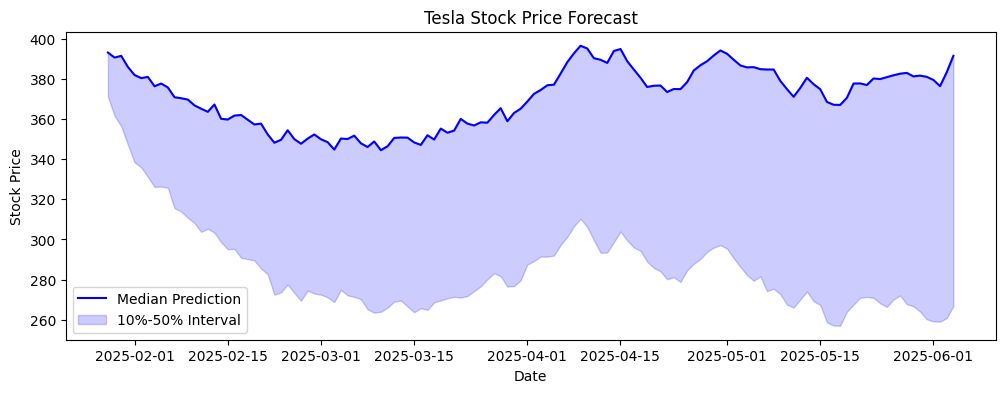

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(forecast_df["ds"], forecast_df["timesfm"], label="Median Prediction", color="blue")
plt.fill_between(
    forecast_df["ds"],
    forecast_df["timesfm-q-0.1"],
    forecast_df["timesfm-q-0.5"],
    color="blue",
    alpha=0.2,
    label="10%-50% Interval"
)
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Tesla Stock Price Forecast")
plt.legend()
plt.show()


# Predicting Tomorrow's TSLA stock price

In [12]:
from datetime import datetime, timedelta

# Generate the next day's datetime
today = datetime.today()
tmr = (today + timedelta(days=1)).date()  

# Ensure both tmr and forecast_df["ds"] are datetime
forecast_df["ds"] = pd.to_datetime(forecast_df["ds"])  # Convert to datetime
filtered_df = forecast_df[forecast_df["ds"].dt.date == tmr]  # Compare dates directly

print(filtered_df)

  unique_id                        ds     timesfm  timesfm-q-0.1  \
0      TSLA 2025-01-28 00:00:00-05:00  393.185944     371.132629   

   timesfm-q-0.2  timesfm-q-0.3  timesfm-q-0.4  timesfm-q-0.5  timesfm-q-0.6  \
0      381.47345     383.681274     388.428741     393.185944     395.407898   

   timesfm-q-0.7  timesfm-q-0.8  timesfm-q-0.9  
0      399.04657     402.175293     413.013885  


In [13]:
print(tmr)

2025-01-28
